In [1]:
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv

from segment_track.fastsam_wrapper import FastSAMWrapper

from robot_utils.robot_data import ImgData, PoseData

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = 'cuda'
FASTSAM_WEIGHTS = '/home/lucas/Workspace/fastsam3d/FastSAM/weights/FastSAM-x.pt'

In [27]:
fastsam = FastSAMWrapper(
    weights=FASTSAM_WEIGHTS,
    device=device,
)
fastsam.setup_filtering(
    clip_embedding=True,
    device=device
)

In [28]:
img_data = ImgData.from_bag(
    path="/home/lucas/Downloads/runA.bag",
    topic="/RR08/l515/color/image_raw/compressed",
    compressed=True
)
pose_data = PoseData.from_bag(
    path="/home/lucas/Downloads/runA.bag",
    topic="/RR08/world"
)

<Axes: >

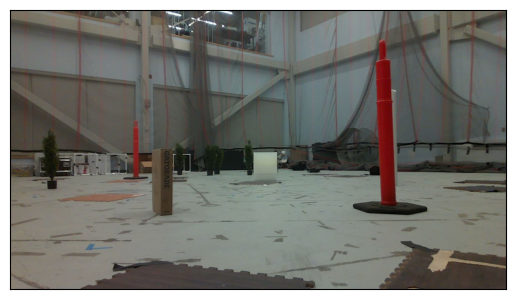

In [29]:
img = img_data.img(img_data.t0)
img_data.show(img_data.t0)

In [30]:
'''
Helper function from Annika
'''
# my function to calculate a boounding box around a mask
def mask_bounding_box(mask):
    # Find the indices of the True values
    true_indices = np.argwhere(mask)

    if len(true_indices) == 0:
        # No True values found, return None or an appropriate response
        return None

    # Calculate the mean of the indices
    mean_coords = np.mean(true_indices, axis=0)

    # print(mean_coords)

    # Calculate the width and height based on the min and max indices in each dimension
    min_row, min_col = np.min(true_indices, axis=0)
    max_row, max_col = np.max(true_indices, axis=0)

    width = max_col - min_col + 1
    height = max_row - min_row + 1

    # Define a bounding box around the mean coordinates with the calculated width and height
    min_row = int(max(mean_coords[0] - height // 2, 0))
    max_row = int(min(mean_coords[0] + height // 2, mask.shape[0] - 1))
    min_col = int(max(mean_coords[1] - width // 2, 0))
    max_col = int(min(mean_coords[1] + width // 2, mask.shape[1] - 1))

    return (min_col, min_row, max_col, max_row,)


In [31]:
t = img_data.t0 + 1
img_org = img_data.img(t)
observations = fastsam.run(t, pose_data.T_WB(t), img_data.img(t))


0: 576x1024 30 objects, 113.9ms
Speed: 3.9ms preprocess, 113.9ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)


Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)
Clip embedding shape:  torch.Size([1, 768])
Img size:  (720, 1280, 3)
Mask shape:  (720, 1280)

<Axes: >

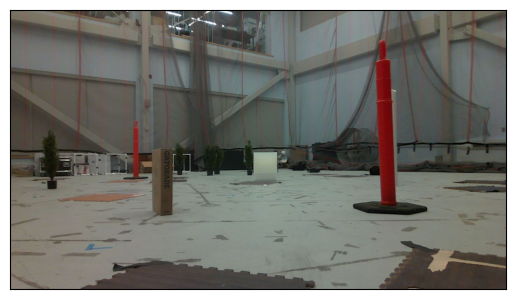

In [32]:
img_data.show(t)

In [33]:
print(len(observations))

30


### Inspect one of the created observations ###

In [34]:
def inspect_obs(img, observations, obs_idx):
    # mask_downsampled =  observations[obs_idx].mask_downsampled
    mask = observations[obs_idx].mask.astype('uint8')
    fig, axes = plt.subplots(1,2)
    img = cv.bitwise_and(img, img, mask = mask)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes[0].imshow(img)
    min_col, min_row, max_col, max_row = mask_bounding_box(mask)
    img_bbox = img[min_row:max_row, min_col:max_col]
    axes[1].imshow(img_bbox)

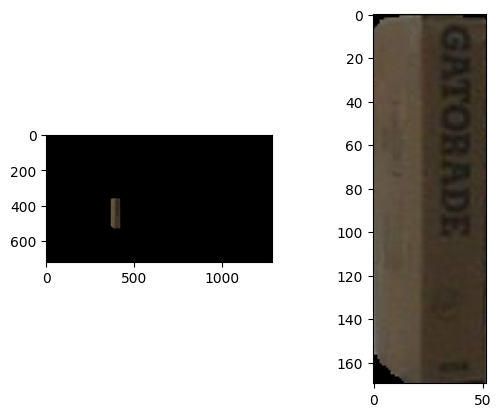

In [35]:
inspect_obs(img_org, observations, 0)

In [ ]:
cosine_similarity = np.zeros((len(observations), len(observations)))
for i in range(len(observations)):
    for j in range(len(observations)):
        embedding_1 = observations[i].clip_embedding
        embedding_2 = observations[j].clip_embedding
        cosine_similarity[i, j] = np.dot(embedding_1, embedding_2)/(np.linalg.norm(embedding_1)*np.linalg.norm(embedding_2))

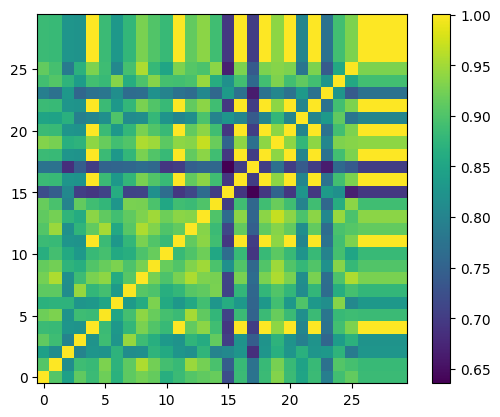

In [37]:
plt.close()
plt.imshow(cosine_similarity, vmin=cosine_similarity.min(), vmax=cosine_similarity.max(), interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

### Inspect segments with high similarity scores ###

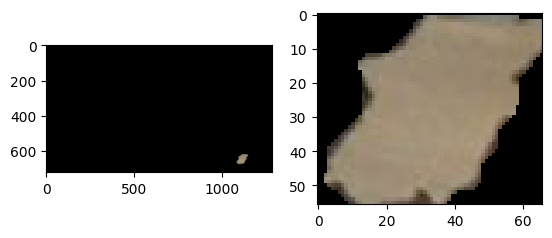

In [38]:
inspect_obs(img_org, observations, 26)

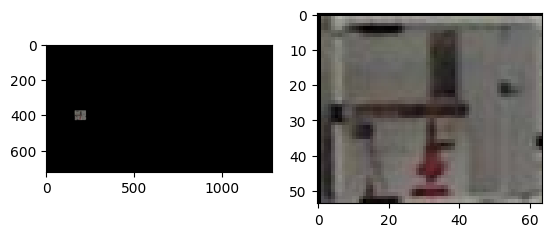

In [39]:
inspect_obs(img_org, observations, 27)

### Try feeding bounding boxes to CLIP ###

In [40]:
clip_embedding_bbox = []
for obs in observations:
    min_col, min_row, max_col, max_row = mask_bounding_box(obs.mask_downsampled)
    img_bbox = img[min_row:max_row, min_col:max_col]
    processed_img = fastsam.clip_preprocess(Image.fromarray(img_bbox)).to(fastsam.device)
    clip_embedding = fastsam.clip_model.encode_image(processed_img.unsqueeze(dim=0))
    clip_embedding_bbox.append(clip_embedding.squeeze().cpu().detach().numpy())

In [43]:
cosine_similarity_bbox = np.zeros((len(observations), len(observations)))
for i in range(len(observations)):
    for j in range(len(observations)):
        embedding_1 = clip_embedding_bbox[i]
        embedding_2 = clip_embedding_bbox[j]
        cosine_similarity_bbox[i, j] = np.dot(embedding_1, embedding_2)/(np.linalg.norm(embedding_1)*np.linalg.norm(embedding_2))

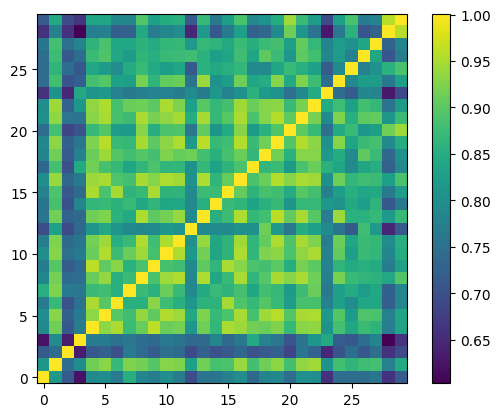

In [44]:
plt.close()
plt.imshow(cosine_similarity_bbox, vmin=cosine_similarity_bbox.min(), vmax=cosine_similarity_bbox.max(), interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

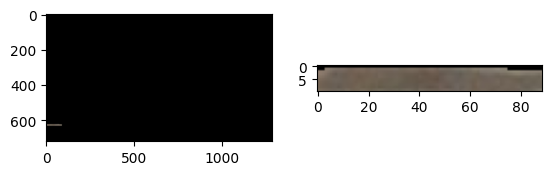

In [45]:
inspect_obs(img_org, observations, 28)

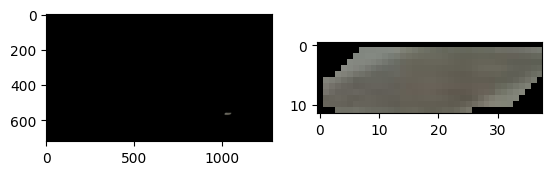

In [46]:
inspect_obs(img_org, observations, 29)

### Investigate Different Views of Same Objects ###

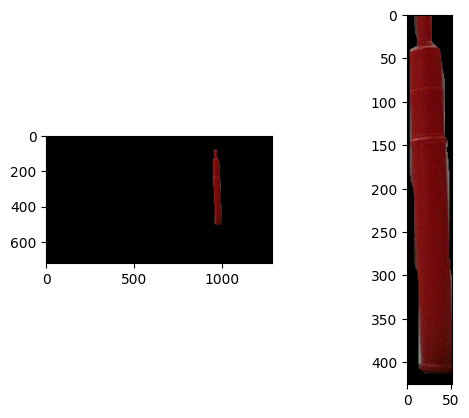

In [51]:
### Pick out the cones.
inspect_obs(img_org, observations, 7)

In [52]:
cone_embedding_1 = clip_embedding_bbox[7]

In [ ]:
t = img_data.t0 + 5
img_next = img_data.img(t)
observations_next = fastsam.run(t, pose_data.T_WB(t), img_data.img(t))

<Axes: >

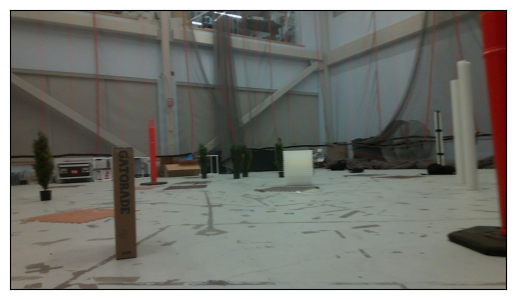

In [60]:
img_data.show(t)

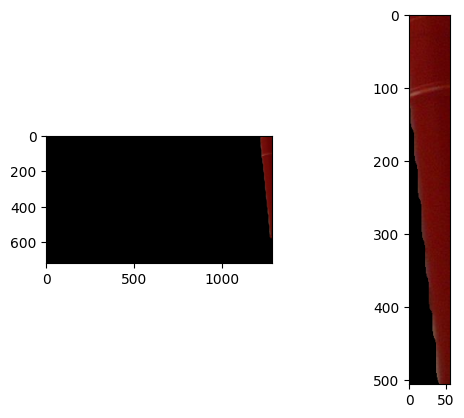

In [73]:
inspect_obs(img_next, observations_next, 11)

In [74]:
idx_diff_cone = 8 ### Index of the left cone
idx_same_cone = 11 ### Index of the right cone

In [81]:
def get_clip_embedding(img, mask):
    min_col, min_row, max_col, max_row = mask_bounding_box(mask)
    img_bbox = img[min_row:max_row, min_col:max_col]
    processed_img = fastsam.clip_preprocess(Image.fromarray(img_bbox)).to(fastsam.device)
    clip_embedding = fastsam.clip_model.encode_image(processed_img.unsqueeze(dim=0))
    return clip_embedding.squeeze().cpu().detach().numpy()

In [82]:
diff_cone_embedding = get_clip_embedding(img_next, observations_next[idx_diff_cone].mask_downsampled)
same_cone_embedding = get_clip_embedding(img_next, observations_next[idx_same_cone].mask_downsampled)

In [84]:
cone_embeddings = [cone_embedding_1, diff_cone_embedding, same_cone_embedding]
M = np.zeros((len(cone_embeddings), len(cone_embeddings)))
for i in range(len(cone_embeddings)):
    for j in range(len(cone_embeddings)):
        M[i, j] = np.dot(cone_embeddings[i], cone_embeddings[j])/(np.linalg.norm(cone_embeddings[i])*np.linalg.norm(cone_embeddings[j]))
    

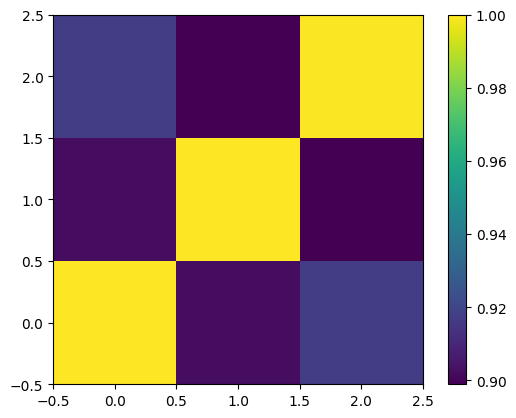

In [85]:
plt.close()
plt.imshow(M, vmin=M.min(), vmax=M.max(), interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()